In [8]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import random
import pandas as pd

In [9]:
from selenium.webdriver.chrome.service import Service
service = Service(ChromeDriverManager().install())



====== WebDriver manager ======
Could not get version for google-chrome with the command:  powershell "$ErrorActionPreference='silentlycontinue' ; (Get-Item -Path "$env:PROGRAMFILES\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion ; if (-not $? -or $? -match $error) { (Get-Item -Path "$env:PROGRAMFILES(x86)\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion } if (-not $? -or $? -match $error) { (Get-Item -Path "$env:LOCALAPPDATA\Google\Chrome\Application\chrome.exe").VersionInfo.FileVersion } if (-not $? -or $? -match $error) { reg query "HKCU\SOFTWARE\Google\Chrome\BLBeacon" /v version } if (-not $? -or $? -match $error) { reg query "HKLM\SOFTWARE\Wow6432Node\Microsoft\Windows\CurrentVersion\Uninstall\Google Chrome" /v version }"
Current google-chrome version is UNKNOWN
Get LATEST chromedriver version for UNKNOWN google-chrome
There is no [win32] chromedriver for browser  in cache
Trying to download new driver from https://chromedriver.storage.googleapis.co

# 무한 스크롤 함수

In [10]:
def scroll():
    try:        
        # 페이지 내 스크롤 높이 받아오기
        last_page_height = driver.execute_script("return document.documentElement.scrollHeight")
        while True:
            # 임의의 페이지 로딩 시간 설정
            # PC환경에 따라 로딩시간 최적화를 통해 scraping 시간 단축 가능
            pause_time = random.uniform(1, 2)
            # 페이지 최하단까지 스크롤
            driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
            # 페이지 로딩 대기
            time.sleep(pause_time)
            # 무한 스크롤 동작을 위해 살짝 위로 스크롤(i.e., 페이지를 위로 올렸다가 내리는 제스쳐)
            driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight-50)")
            time.sleep(pause_time)
            # 페이지 내 스크롤 높이 새롭게 받아오기
            new_page_height = driver.execute_script("return document.documentElement.scrollHeight")
            # 스크롤을 완료한 경우(더이상 페이지 높이 변화가 없는 경우)
            if new_page_height == last_page_height:
                print("스크롤 완료")
                break
                
            # 스크롤 완료하지 않은 경우, 최하단까지 스크롤
            else:
                last_page_height = new_page_height
            
    except Exception as e:
        print("에러 발생: ", e)

# 데이터 스크랩

### 검색 키워드 설정

In [ ]:
# 검색 리스트
# 엑셀에서 검색어 추출
df = pd.read_excel("파   일    명", sheet_name= "")  # 경로 바꿔주셔야돼요!
data_list = []

검색 키워드를 위 리스트에서 하나씩 받아오자

In [14]:
# 검색 키워드 설정: 키워드 내 띄어쓰기는 URL에서 '+'로 표시되기 때문에 이에 맞게 변환
SEARCH_KEYWORD = '아이폰 14'.replace(' ', '+')

### 드라이버 세팅 및 실행

In [15]:
driver = webdriver.Chrome(service=service)
# 스크래핑 할 URL 세팅
URL = "https://www.youtube.com/results?search_query=" + SEARCH_KEYWORD
# 크롬 드라이버를 통해 지정한 URL의 웹 페이지 오픈
driver.get(URL)
# 웹 페이지 로딩 대기
time.sleep(3)
# 무한 스크롤 함수 실행
scroll()

스크롤 완료


### 페이지 소스 추출

In [16]:
# 페이지 소스 추출
html_source = driver.page_source
soup_source = BeautifulSoup(html_source, 'html.parser')

# 데이터 추출

In [17]:
# 콘텐츠 모든 정보
content_total = soup_source.find_all(class_ = 'yt-simple-endpoint style-scope ytd-video-renderer')
# 콘텐츠 제목만 추출
content_total_title = list(map(lambda data: data.get_text().replace("\n", ""), content_total))
# 콘텐츠 링크만 추출
content_total_link = list(map(lambda data: "https://youtube.com" + data["href"], content_total))

#--------조회수 & 업로드 날짜 추출(Updated at 2022-10-11)--------#
content_record_src = soup_source.find_all(class_ = 'style-scope ytd-video-meta-block')
content_view_cnt = [content_record_src[i].get_text().replace('조회수 ', '') for i in range(5, len(content_record_src), 10)]
content_upload_date = [content_record_src[i].get_text() for i in range(6, len(content_record_src), 10)]
#---------------------------------------------------------#

# 딕셔너리 포맷팅
content_total_dict = {'title'       : content_total_title, 
                      'link'        : content_total_link, 
                      'view'        : content_view_cnt,
                      'upload_date' : content_upload_date
                     }

# 데이터 프레임 포맷팅

In [19]:
content_total_dict

{'title': ['아이폰14 일반/플러스 사면 호구 인증이다? 갈등하는 분들을 위한 아이폰14 선택 가이드',
  '아이폰14 구매가이드!! 고민 해결해 드립니다',
  '5년만에 사라진 노치. 기다렸던 아이폰14 프로&프로 맥스 언빡싱과 첫 인상!',
  '아이폰14 프로 말고 일반은 어때요? 아이폰14 달라진 점 & 구매 가이드',
  '아이폰14, 14프로 사자마자 무조건 해야하는 초기불량 테스트!!!!(디스플레이, 번개액정, 벚꽃액정, 스피커 등등)',
  '채민이의 아이폰이 산산조각 났대요! ㅠㅠ 이게 무슨일이죠..?｜클레버TV',
  '안하면 2년동안 손해보는 아이폰14 초기 설정 16가지! [아이폰14/14pro/iOS16]',
  '컴퓨터가격이라는 200만원짜리 아이폰14프로 구입하였습니다! 도대체 비싼 이유는?!',
  '내가 아이폰14 프로 대신 아이폰14 일반을 선택한 이유! 💙 (아이폰14 프로 vs 일반 차이점 정리)',
  '갤럭시만 5년 쓰다가 아이폰14pro로 바꾼 후기',
  '100% 활용법! 아이폰 14프로 액키스만 모아온 핵심꿀팁 12가지 총정리',
  '아이폰14 시리즈 실사용 후기 장점&단점 알려드림, 전모델 가져왔습니다',
  '아이폰14 살까말까? 찝찝한 3분정리.',
  '아이폰만 14년 썼어요. 그냥 믿고 따라하세요. [아이폰14 초기설정 완벽정리]',
  'iPhone 14 vs iPhone 11 - SPEED TEST',
  '아이폰15 존버합시다. 아이폰15 울트라 미쳤으니까!😲 (잠망경카메라 / 다이나믹아일랜드 / USB-C)',
  '깜짝 선물로 아이폰14 를 선물 받은 태국 여자친구의 역대급 반응 (감동주의)',
  '에버랜드에 숨긴 아이폰14프로 찾기ㅋㅋㅋㅋㅋ',
  '(비교적) 싼데 큰 플러스 포함 정발된 아이폰 14 시리즈 전부 비교',
  '노치, 여기 묻히다. 아이폰 14 & 14 프로 개봉기',
  '아이폰14프로 갈아탈 만 하냐고요? 아이폰13프로와 꼼꼼 비교!',
  '아이폰14프로 2

In [31]:
del content_total_dict['view']
del content_total_dict['upload_date']

In [32]:
df = pd.DataFrame(content_total_dict)
df

,title,link
0,아이폰14 일반/플러스 사면 호구 인증이다? 갈등하는 분들을 위한 아이폰14 선택 가이드,https://youtube.com/watch?v=Qk77K6XQfYs
1,아이폰14 구매가이드!! 고민 해결해 드립니다,https://youtube.com/watch?v=A2awOBIKlS0
2,5년만에 사라진 노치. 기다렸던 아이폰14 프로&프로 맥스 언빡싱과 첫 인상!,https://youtube.com/watch?v=VOEmkMqcxwU
3,아이폰14 프로 말고 일반은 어때요? 아이폰14 달라진 점 & 구매 가이드,https://youtube.com/watch?v=bq5mV4tcVnI
4,"아이폰14, 14프로 사자마자 무조건 해야하는 초기불량 테스트!!!!(디스플레이, ...",https://youtube.com/watch?v=7h03FLZyelM
...,...,...
668,Fake iPhone 14 Pro Max #iphone14promax,https://youtube.com/shorts/XnkZqgUz1tc
669,اهم مميزات ايفون 14 برو ماكس || Iphone 14 pro ...,https://youtube.com/shorts/9v3x0U6Q5Z8
670,[뿌드컵 5일차 2부 EP14] 지면 끝나는 경기에 신상 월드컵 금카까지 등장! 피파4,https://youtube.com/watch?v=uS6GiZO1Yeo
671,독일을 월드컵에서 꺾은 아시아 유일팀! 대한민국 축구의 희망을 보았던 2018 월드...,https://youtube.com/watch?v=jvjZ_eHFDT4


# 데이터 저장

In [34]:
df.to_csv("./content_total.csv", encoding='utf-8-sig')

# 링크로 영상 보여주기

In [37]:
from IPython.display import YouTubeVideo
from IPython.display import HTML

In [38]:
HTML('Https://youtube.com/watch?v=Qk77K6XQfYs')

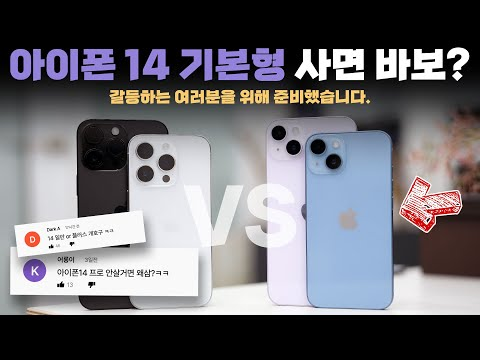

In [40]:
YouTubeVideo('Qk77K6XQfYs', width=600, height=400)

# 썸네일까지 저장하는 코드

In [ ]:
# 데이터 처리
import pandas as pd
from pandas import DataFrame
import openpyxl

# selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager # webdriver-manager 패키지 다운로드
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys

# 시간 명시
from tqdm import tqdm
import time

# 오류 확인
import traceback

## Webdirver option 설정
options = webdriver.ChromeOptions()
# options.add_argument('headless') # 크롬 띄우는 창 없애기
options.add_argument('window-size=1920x1080') # 크롬드라이버 창크기
options.add_argument("disable-gpu") #그래픽 성능 낮춰서 크롤링 성능 쪼금 높이기
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36") # 네트워크 설정
options.add_argument("lang=ko_KR") # 사이트 주언어
driver = webdriver.Chrome(ChromeDriverManager().install(),chrome_options=options)

# 엑셀에서 검색어 추출
df = pd.read_excel("C:/Users/코딩하는 금융인/Desktop/sample data.xlsx")  # 경로 바꿔주셔야돼요!
data_list = []

# Main Code
for idx, row in tqdm(df.iterrows(), desc="돌리는중"):
    cd_idx = row['cd_idx']
    search_name = row['cop_youtube_search']
    print(search_name)
    try:
        youtubeUrl = (f"https://www.youtube.com/results?search_query={search_name}")
        # url에 &sp=QgIIAQ%253D%253D : 검색 입력어 그대로 검색.
        # 유튜브는 검색이 이상하면 자동으로 검색 조정해줌.
        driver.get(youtubeUrl)
        time.sleep(0.1)
        # driver.execute_script("window.scrollTo(0, 80000)")
        no_of_pagedowns = 5
        elem = driver.find_element_by_tag_name("body")
        # print("Scrolling Down!")
        while no_of_pagedowns:
            # print(10 - no_of_pagedowns, "th Scroll")
            elem.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.5)
            no_of_pagedowns -= 1
        time.sleep(5) #sleep을 통해 Robot Error 해결.
        num = 0
        box_list = driver.find_elements_by_css_selector("#contents > ytd-video-renderer")
        # 검색결과 미존재 통과
        '''
        if box_list == None:
            print("there is no search result!")
         '''
        for box in box_list:
            title = box.find_element_by_css_selector('#video-title')
            link = title.get_attribute("href")
            title_name = box.find_element_by_css_selector('#video-title').text
            img_ = box.find_element_by_css_selector('#img')
            img = img_.get_attribute('src')
            name = box.find_element_by_css_selector('#text > a').text
            duration = box.find_element_by_css_selector('#overlays > ytd-thumbnail-overlay-time-status-renderer > span').text
            regdate_ment = box.find_element_by_css_selector('#metadata-line > span:nth-child(2)').text
            viewcount = box.find_element_by_css_selector('#metadata-line > span:nth-child(1)').text

            data = {"cd_idx": cd_idx, 'cop_youtube_search': search_name, "link": link, "title_name": title_name,
                    "title_text": title_text, "image": img, "name": name,
                    "duration": duration, "regdate_ment": regdate_ment, "viewcount": viewcount}
            data_list.append(data)
            num += 1
            if (num == 10):
                break
    # 중간 검색어 오류 시 비상 저장
    except:
        print(idx)
        result_df = pd.DataFrame(data_list,columns=['cd_idx', 'cop_youtube_search', 'link', 'title_name', 'image','name',
                                                    'duration', 'regdate_ment', 'viewcount'])
        result_df.to_excel(f'C:/Users/코딩하는 금융인/Desktop/result data.xlsx', index=False)  # 경로 바꿔주셔야 돼요.
        # driver.close()

result_df = pd.DataFrame(data_list,columns=['cd_idx', 'cop_youtube_search', 'link', 'title_name', 'image','name',
                                                    'duration', 'regdate_ment', 'viewcount'])
result_df.to_excel(f'C:/Users/코딩하는 금융인/Desktop/result data.xlsx', index=False)